In [25]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
from sklearn.manifold import TSNE

In [26]:
review_csv = pd.read_csv('Reviews.csv')
review_csv.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [27]:
reviews_subset = review_csv.sample(n=2000)
reviews_subset.shape

(2000, 10)

In [28]:
actual_set = reviews_subset[reviews_subset['Score']!= 3]
actual_set.shape

(1859, 10)

In [32]:
actual_set['UserId'].value_counts()
actual_set[actual_set['UserId'] == 'A2N5YX7DLGPG3K']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
354813,354814,B003YV46WK,A2N5YX7DLGPG3K,Fred H.,0,17,5,1215734400,"Oh, Yes....",There are so many beverages that people can dr...
144452,144453,B000G18NS4,A2N5YX7DLGPG3K,Fred H.,0,0,5,1349222400,"Oh, yeah....",The only refried beans I ate for the longest t...


<h4>No deduplication here

In [33]:
print(actual_set.shape)
actual_set[actual_set['HelpfulnessNumerator'] <= actual_set['HelpfulnessDenominator']].shape

(1859, 10)


(1859, 10)

<h4>Here data is correct as value of HelpfulnessNumerator is less than equal to HelpfulnessDenominator

In [34]:
def partition(x):
    if x < 3:
        return 0
    return 1

positiveNegative = actual_set['Score'].map(partition) 
actual_set['Score'] = positiveNegative

actual_set['Score'].value_counts()

1    1585
0     274
Name: Score, dtype: int64

# 0 - Reviews < 3
# 1 - Reviews > 3

In [35]:
i=0;
for sent in actual_set['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

0
Was hotter than i thought. Was very good but too much jerky all at once but addictive.<br />If you eat too many you might be burping up a hot taste for a while.


In [36]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)

{'to', 'don', 'other', 'both', 'didn', 'won', 'for', 'my', 'and', 'so', 'y', 'a', 'all', 'did', 'through', 'i', 'their', 'until', 'is', 'an', 'the', 'has', 'only', 'they', 'too', 'themselves', 'most', 'which', 'very', 'just', 'hadn', 'wasn', 'will', 'herself', 'about', 'between', 'own', 'aren', 've', 'more', 'off', 'because', 'those', 'some', 'further', 'he', 'our', 'who', 'before', 't', 'ma', 's', 'during', 'm', 'after', 'do', 'not', 'can', 'these', 'am', 'then', 'had', 'into', 'are', 'nor', 'theirs', 'should', 'd', 'doesn', 'your', 'hers', 'haven', 'what', 'few', 'me', 'again', 'been', 'were', 'she', 'there', 'above', 'such', 're', 'ourselves', 'shan', 'ain', 'out', 'yourself', 'if', 'once', 'itself', 'them', 'that', 'his', 'as', 'yours', 'when', 'yourselves', 'whom', 'her', 'now', 'over', 'but', 'mightn', 'needn', 'its', 'having', 'by', 'you', 'him', 'it', 'where', 'o', 'down', 'under', 'shouldn', 'we', 'couldn', 'myself', 'ours', 'weren', 'at', 'below', 'isn', 'hasn', 'against', 'w

In [37]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in tqdm(actual_set['Text'].values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (actual_set['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(actual_set['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words

    final_string.append(str1)
    i+=1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1859/1859 [00:04<00:00, 436.27it/s]


In [38]:
actual_set['Cleaned_text'] = final_string

# BoW

In [39]:
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(actual_set['Cleaned_text'].values)
print("Shape of BoW",final_counts.get_shape())
print("Unique Words ", final_counts.get_shape()[1])

Shape of BoW (1859, 6093)
Unique Words  6093


# t-SNE BoW

In [40]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=1000, n_iter=7, random_state=42)
reduced_matrix = svd.fit_transform(final_counts)
reduced_matrix.shape

(1859, 1000)

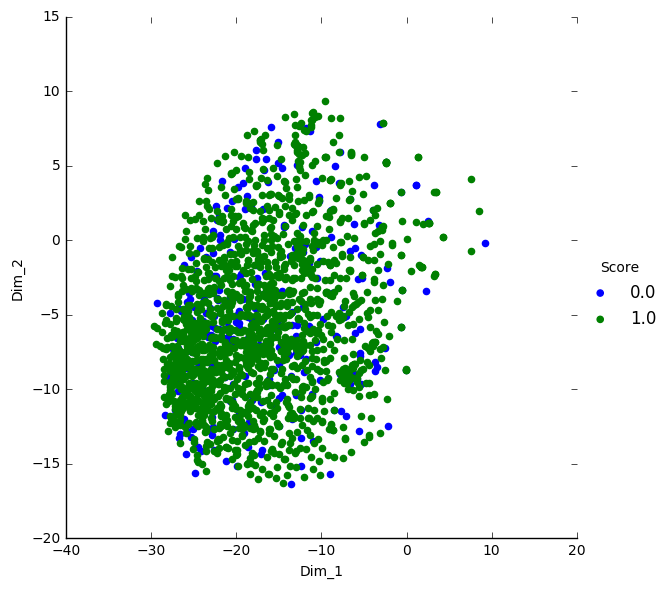

In [41]:
labels = actual_set['Score']
# print(labels.head())

model = TSNE(n_components=2, random_state=0)
# perplexity - default perplexity = 30
tsne_data = model.fit_transform(reduced_matrix)
# print(tsne_data.shape)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
# print(tsne_df.head)
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

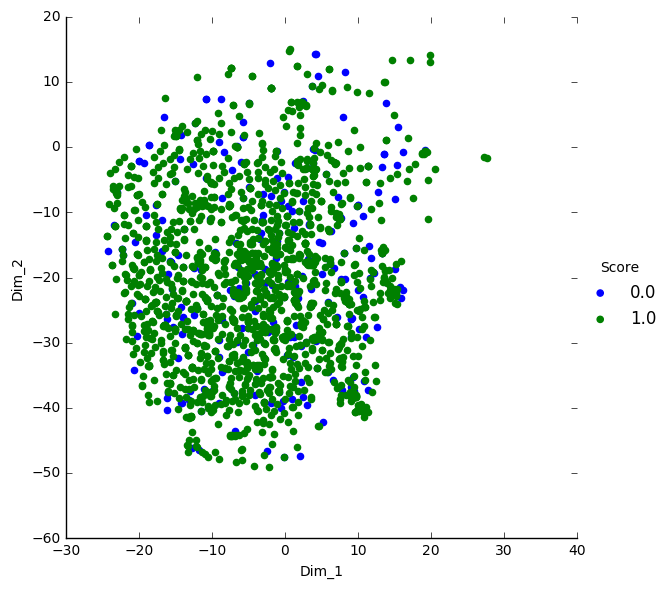

In [42]:
labels = actual_set['Score']
# print(labels.head())

model = TSNE(n_components=2, random_state=0, perplexity=2)
# perplexity - perplexity = 2
tsne_data = model.fit_transform(reduced_matrix)
# print(tsne_data.shape)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
# print(tsne_df.head)
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

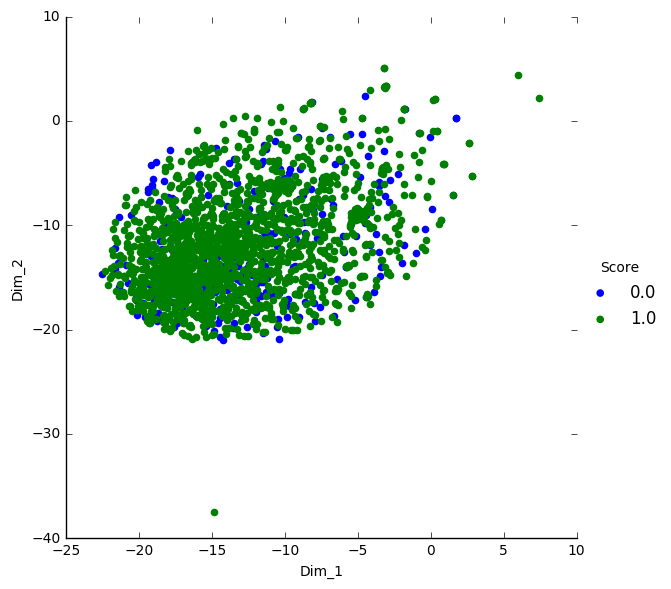

In [44]:
labels = actual_set['Score']
# print(labels.head())

model = TSNE(n_components=2, random_state=0, perplexity=50)
# perplexity = 50
tsne_data = model.fit_transform(reduced_matrix)
# print(tsne_data.shape)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
# print(tsne_df.head)
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# TF-IDF

In [94]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(actual_set['Cleaned_text'].values)
print("shape of TFIDF",final_tf_idf.get_shape())
print("Unique Words", final_tf_idf.get_shape()[1])

shape of TFIDF (1831, 60016)
Unique Words 60016


In [95]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[1001:1010])

some sample features(unique words in the corpus) ['allerg reaction', 'allerg real', 'allerg trip', 'allergi', 'allergi age', 'allergi certain', 'allergi con', 'allergi corn', 'allergi excit']


In [96]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [97]:
top_tfidf

,feature,tfidf
0,espresso,0.215856
1,cappuccino,0.205198
2,red,0.181543
3,tea,0.161788
4,red espresso,0.150103
5,rooibo tea,0.142320
6,rooibo,0.132515
7,uniqu,0.114174
8,someth,0.113996
9,ice tea,0.109025


# t-SNE for TF-IDF

In [98]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=1000, n_iter=7, random_state=42)
reduced_matrix = svd.fit_transform(final_tf_idf)
reduced_matrix.shape

(1831, 1000)

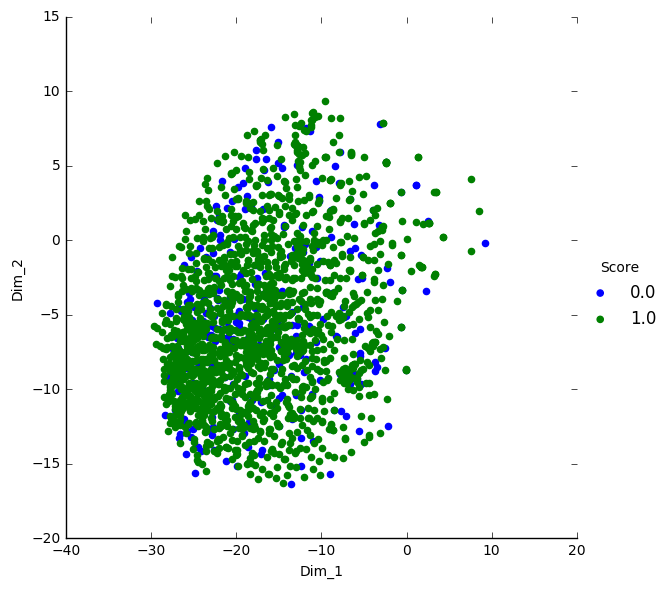

In [45]:
labels = actual_set['Score']
# print(labels.head())

model = TSNE(n_components=2, random_state=0)
# default perplexity = 30

tsne_data = model.fit_transform(reduced_matrix)
# print(tsne_data.shape)

tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
# print(tsne_df.head)
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

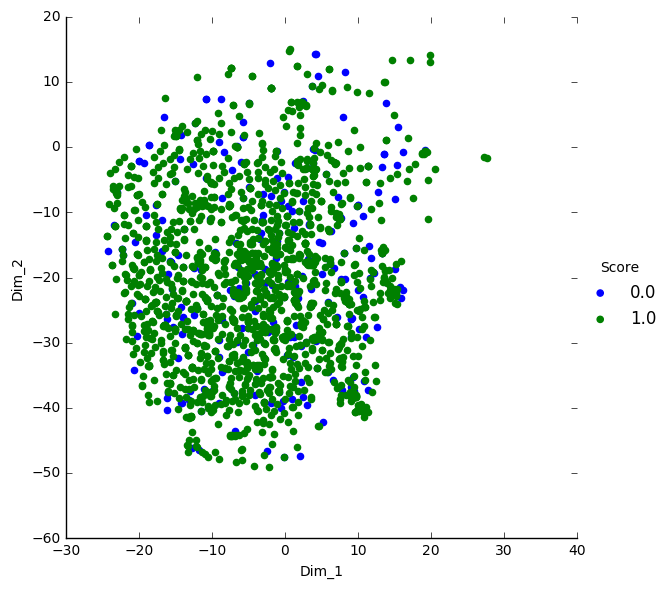

In [46]:
labels = actual_set['Score']
# print(labels.head())

model = TSNE(n_components=2, random_state=0, perplexity =2)
# perplexity = 2

tsne_data = model.fit_transform(reduced_matrix)
# print(tsne_data.shape)

tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
# print(tsne_df.head)
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

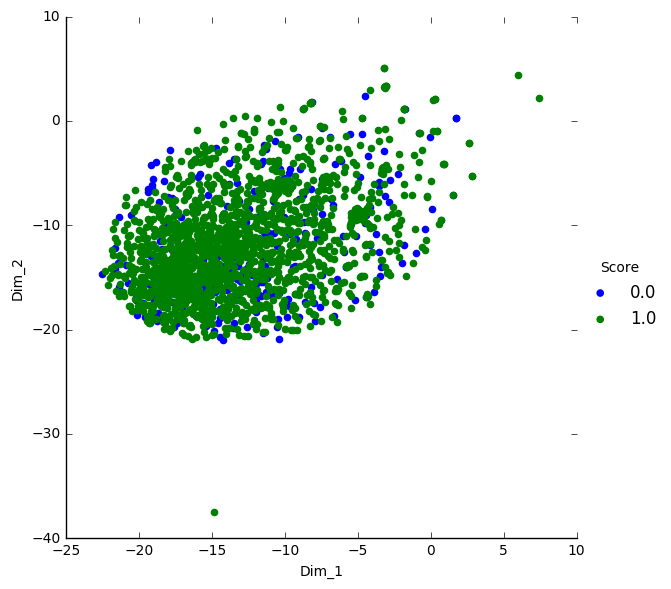

In [47]:
labels = actual_set['Score']
# print(labels.head())

model = TSNE(n_components=2, random_state=0, perplexity =50)
# perplexity = 50

tsne_data = model.fit_transform(reduced_matrix)
# print(tsne_data.shape)

tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
# print(tsne_df.head)
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# Avg Word2Vec

In [51]:
actual_set['Cleaned_text']=actual_set['Cleaned_text'].str.decode("utf-8")

In [52]:
i=0
word_list=[]
for sent in actual_set['Cleaned_text'].values:
    word_list.append(sent.split())

In [53]:
print(actual_set['Text'].values[0])
print("*****************************************************************")
print(word_list[0])

Was hotter than i thought. Was very good but too much jerky all at once but addictive.<br />If you eat too many you might be burping up a hot taste for a while.
*****************************************************************
['hotter', 'thought', 'good', 'much', 'jerki', 'addict', 'eat', 'mani', 'might', 'burp', 'hot', 'tast']


In [54]:
w2v_model=Word2Vec(word_list,min_count=5,size=50, workers=4)

In [55]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  1906
sample words  ['sort', 'rabbit', 'powder', 'usa', 'bed', 'everyon', 'yeast', 'better', 'notch', 'cupboard', 'degre', 'juic', 'posit', 'whip', 'sweeter', 'dietari', 'shock', 'yummi', 'women', 'weak', 'pink', 'hype', 'truffl', 'cracker', 'arent', 'core', 'indoor', 'sister', 'bath', 'desir', 'bowl', 'refer', 'joe', 'bone', 'discontinu', 'day', 'mislead', 'brought', 'kill', 'homemad', 'start', 'grade', 'splenda', 'grown', 'moon', 'supplement', 'suppos', 'bare', 'quantiti', 'thank']


In [56]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(word_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1859/1859 [00:03<00:00, 605.29it/s]


1859
50


# t-SNE for Avg Word2Vec

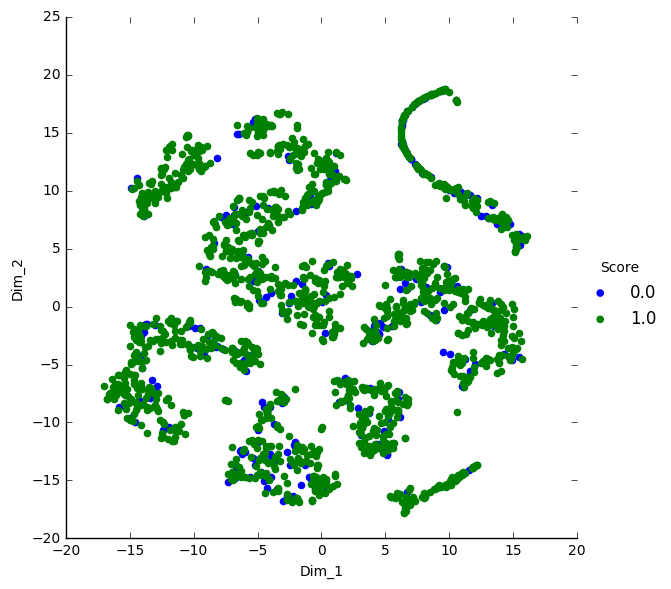

In [57]:
labels = actual_set['Score']
# print(labels.head())

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(sent_vectors)
# print(tsne_data.shape)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
# print(tsne_df.head)
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

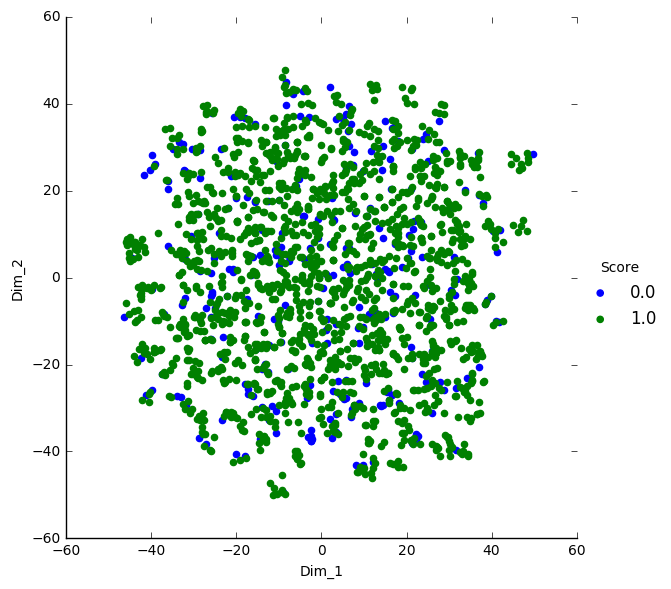

In [58]:
labels = actual_set['Score']
# print(labels.head())

model = TSNE(n_components=2, random_state=0, perplexity = 2)
# configuring the parameteres
# the number of components = 2
# perplexity = 2
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(sent_vectors)
# print(tsne_data.shape)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
# print(tsne_df.head)
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

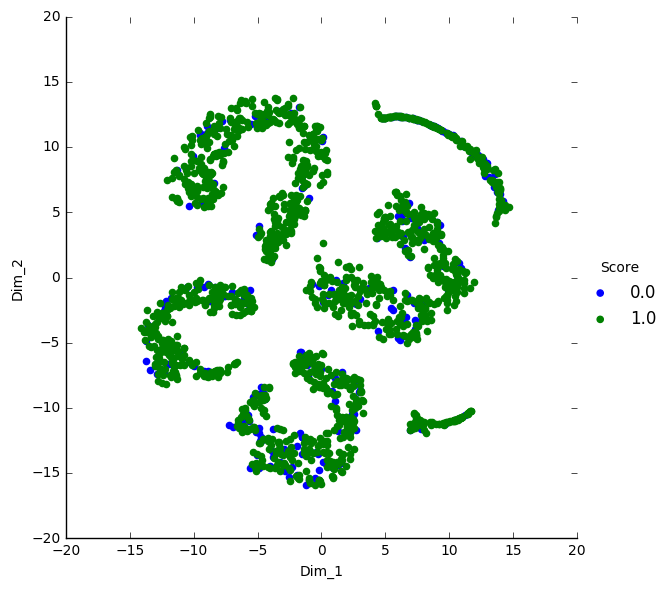

In [59]:
labels = actual_set['Score']
# print(labels.head())

model = TSNE(n_components=2, random_state=0, perplexity = 50)
# configuring the parameteres
# the number of components = 50
# perplexity = 2
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(sent_vectors)
# print(tsne_data.shape)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
# print(tsne_df.head)
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# TF-IDF - Word2Vec

In [60]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(actual_set['Cleaned_text'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
dictionary['good']

2.3137236682850553

In [61]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names

# t-SNE for TF-IDF -Word2Vec

In [62]:
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(word_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1859/1859 [00:03<00:00, 502.17it/s]


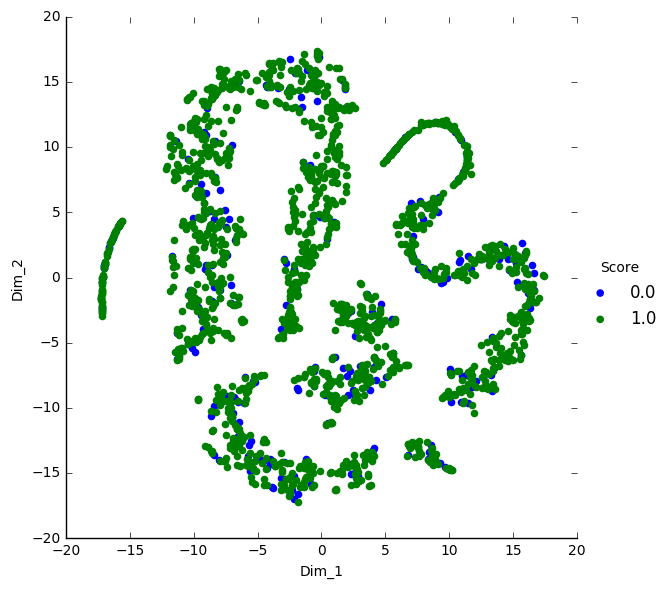

In [63]:
labels = actual_set['Score']
# print(labels.head())

model = TSNE(n_components=2, random_state=0)

tsne_data = model.fit_transform(tfidf_sent_vectors)
# print(tsne_data.shape)

tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
# print(tsne_df.head)

sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

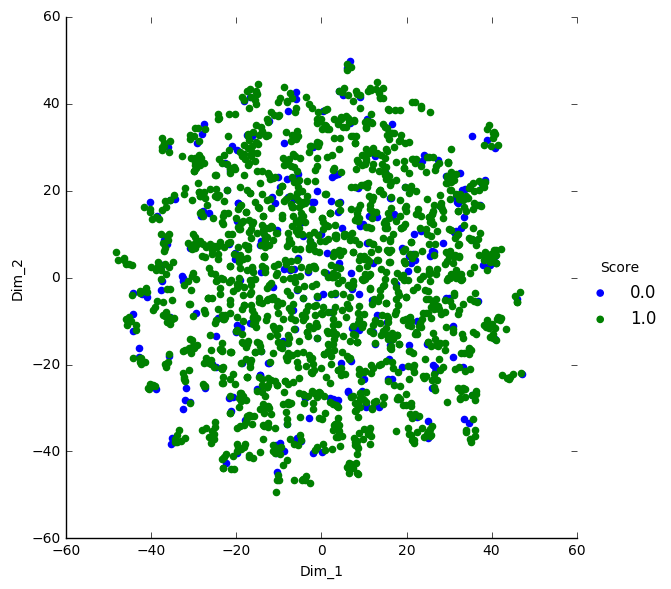

In [65]:
labels = actual_set['Score']
# print(labels.head())

model = TSNE(n_components=2, random_state=0, perplexity = 2)

#perplexity = 2

tsne_data = model.fit_transform(tfidf_sent_vectors)
# print(tsne_data.shape)

tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
# print(tsne_df.head)

sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

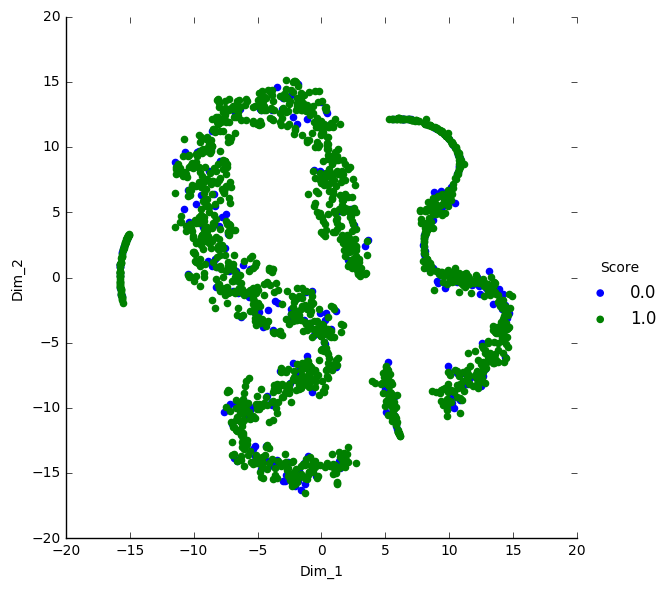

In [66]:
labels = actual_set['Score']
# print(labels.head())

model = TSNE(n_components=2, random_state=0, perplexity = 50)

#perplexity = 50

tsne_data = model.fit_transform(tfidf_sent_vectors)
# print(tsne_data.shape)

tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
# print(tsne_df.head)

sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()